In [1]:
import math
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage as scipy_ndimage
import torch
from IPython.display import Image, display
from matplotlib.animation import FuncAnimation, PillowWriter
from tqdm import tqdm

device = "cuda"
torch.set_float32_matmul_precision("high")

In [2]:
def initialize_grid(seed: int, grid_dim: int, p_alive: float) -> np.ndarray:
    """Initialize a Game of Life grid randomly."""
    grid = np.random.default_rng(seed=seed).uniform(size=[grid_dim, grid_dim])
    grid = grid < p_alive
    return grid.astype(int)


def next_life_step(before_grid: np.ndarray) -> np.ndarray:
    """Calculate the next generation grid in Conway's Game of Life."""
    neighbour_counts = scipy_ndimage.convolve(
        before_grid, weights=[[1, 1, 1], [1, 0, 1], [1, 1, 1]], mode="wrap"
    )
    if_3_neighbours = neighbour_counts == 3
    if_alive_and_2_neighbours = (before_grid == 1) & (neighbour_counts == 2)
    after_grid = if_3_neighbours | if_alive_and_2_neighbours
    return after_grid.astype(int)


class LifeDataset(torch.utils.data.IterableDataset):
    """Generates training examples - Life grid before/after pairs"""

    def __init__(self, grid_dim: int, p_alive: float, idx_offset: int = 0):
        self.grid_dim = grid_dim
        self.p_alive = p_alive
        self.idx_offset = idx_offset

    def __iter__(self):
        idx = 0
        while True:
            before_grid = initialize_grid(
                seed=idx + self.idx_offset, grid_dim=self.grid_dim, p_alive=self.p_alive
            )
            after_grid = next_life_step(before_grid=before_grid)

            # add in more steps...
            for _ in range(random.randint(0, 1)):
                before_grid, after_grid = after_grid, next_life_step(
                    before_grid=after_grid
                )

            yield before_grid, after_grid
            idx += 1


def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)


In [3]:
def weight_matrix(h: int, w: int, type="weight"):
    w = torch.empty(h, w)
    # For why weights are transposed, see here,
    # https://github.com/pytorch/pytorch/issues/129834
    if type == "weight":
        torch.nn.init.kaiming_uniform_(w.T, a=math.sqrt(5))
    elif type == "embedding":
        torch.nn.init.normal_(w.T)
    else:
        raise ValueError("Unsupported `init`")
    return torch.nn.Parameter(w)


class SingleAttentionNet(torch.nn.Module):

    def __init__(self, grid_dim: int, ndim: int):
        super().__init__()
        self.num_grid_cells = grid_dim * grid_dim
        self.sqrt_ndim = math.sqrt(ndim)
        self.W_state = weight_matrix(h=2, w=ndim, type="embedding")
        self.W_positional = weight_matrix(
            h=self.num_grid_cells, w=ndim, type="embedding"
        )
        self.W_q = weight_matrix(h=ndim, w=ndim, type="weight")
        self.W_k = weight_matrix(h=ndim, w=ndim, type="weight")
        self.W_v = weight_matrix(h=ndim, w=ndim, type="weight")
        self.W_h = weight_matrix(h=ndim, w=ndim, type="weight")
        self.W_c = weight_matrix(h=ndim, w=1, type="weight")

    def forward(self, life_grids: torch.Tensor) -> dict[str, torch.Tensor]:
        # The input is a batch of grids,
        # life_grids.shape = [b, grid_dim, grid_dim],

        # Flatten the grids, each cell will become a token
        x = life_grids.reshape(-1, self.num_grid_cells)  # [b, num_grid_cells]

        # Use the embeddings to create tokens representing the grids
        x = self.W_state[x] + self.W_positional  # [b, num_grid_cells, ndim]

        # Single-head attention
        q = x @ self.W_q  # [b, num_grid_cells, ndim]
        k = x @ self.W_k  # [b, num_grid_cells, ndim]
        attention_matrix = torch.softmax(
            q @ k.transpose(-1, -2) / self.sqrt_ndim, dim=-1
        )  # [b, num_grid_cells, num_grid_cells]
        v = x @ self.W_v  # [b, num_grid_cells, ndim]
        x = x + attention_matrix @ v  # skip connection, [b, num_grid_cells, ndim]

        # # Hidden layer
        x = x + torch.nn.functional.silu(x @ self.W_h)  # [b, num_grid_cells, ndim]

        # # Classifier head
        x = x @ self.W_c  # [b, num_grid_cells, 1]

        return x, attention_matrix

In [ ]:
# Stopping conditions
max_training_seconds = 1000 * 60
num_batches_with_full_acc = 10_000

save_attention_matrix_every_n_seconds = 1

# Training hyperparams
batch_size = 32
ndim = 2048
grid_dim = 16


# Note, it's very sensitive to the seed
# and you may need to change it for your system,
# try a few.
seed_everything(549385845)

dataloader = torch.utils.data.DataLoader(
    LifeDataset(grid_dim=grid_dim, p_alive=0.5),
    batch_size=batch_size,
    num_workers=1,
    shuffle=False,
)
model = torch.compile(SingleAttentionNet(grid_dim=grid_dim, ndim=ndim).to(device))
optimizer = torch.optim.SGD(
    params=model.parameters(), lr=0.005, momentum=0.9
)  # worked well

t_start = time.monotonic()
iter_vals = []
saved_attention_matrices = []
model.train()
for batch_idx, (before_grids, after_grids) in enumerate(pbar := tqdm(dataloader)):
    before_grids, after_grids = before_grids.to(device), after_grids.to(device)
    after_grids_pred, attention_matrix = model(before_grids)
    loss = torch.nn.functional.binary_cross_entropy_with_logits(
        input=after_grids_pred.flatten(),
        target=after_grids.flatten().float(),
        reduction="mean",
    )
    with torch.no_grad():
        after_grids_pred_binary = after_grids_pred > 0
        accuracy_val = (
            torch.mean(
                after_grids_pred_binary.flatten() == after_grids.flatten(),
                dtype=torch.float,
            )
            .detach()
            .item()
        )

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    loss_val = loss.detach().item()
    train_duration_seconds = time.monotonic() - t_start
    iter_vals.append(
        {
            "loss": loss_val,
            "accuracy": accuracy_val,
            "train_duration_seconds": train_duration_seconds,
            "batch_idx": batch_idx,
        }
    )
    pbar.set_postfix(
        {
            "%": 100 * train_duration_seconds / max_training_seconds,
            **iter_vals[-1],
            "saved_attention_matrices": len(saved_attention_matrices),
        }
    )

    if (
        len(saved_attention_matrices) * save_attention_matrix_every_n_seconds
        < train_duration_seconds
    ):
        saved_attention_matrices.append(
            {
                "attention_matrix": attention_matrix.detach().cpu().numpy(),
                "batch_idx": batch_idx,
            }
        )

    # Stopping conditions
    if train_duration_seconds > max_training_seconds:
        print(f"Stopping training, exceeded max_training_seconds.")
        break
    elif (len(iter_vals) > num_batches_with_full_acc) and all(
        x["accuracy"] == 1.0 for x in iter_vals[-num_batches_with_full_acc:]
    ):
        print(
            f"Stopping training, due to {num_batches_with_full_acc} having full accuracy."
        )
        break

19921it [22:59, 14.44it/s, %=2.3, loss=2.04e-5, accuracy=1, train_duration_seconds=1.38e+3, batch_idx=19921, saved_attention_matrices=1380] 

Stopping training, due to `num_batches_with_100_acc` having full accuracy.


## Check the model works

In [5]:
# We can assert that the matrix is attending to the 8 neighbours, like we expect
final_attention_matrix_batch = saved_attention_matrices[-1]["attention_matrix"][-1]
for matrix in final_attention_matrix_batch:
    matrix = (matrix > 0.05).sum(axis=0)
    all_eight = np.all(matrix == 8)
    if not all_eight:
        raise ValueError(
            "Neighbour matrix doesn't attend to exactly 8 cells per cell..."
        )

In [6]:
# Run a lot of Life games as an easy way to check the model works
num_games = 10_000
num_steps = 100
for seed in tqdm(
    range(num_games), desc=f"Run {num_games} Life games for {num_steps} steps to check transformer works"
):
    before_grid = initialize_grid(seed=seed, grid_dim=grid_dim, p_alive=0.4)
    for _ in range(100):
        after_grid = next_life_step(before_grid)
        with torch.no_grad():
            after_grid_pred, _ = model(before_grid)
        after_grid_pred = after_grid_pred.detach().cpu().numpy()
        after_grid_pred = (after_grid_pred.reshape(grid_dim, grid_dim) > 0).astype(int)
        if not np.all(after_grid_pred == after_grid):
            raise RuntimeError("Model made a mistake")
        before_grid = after_grid_pred

Run 10000 Life games for 100 steps to check transformer works: 100%|██████████| 10000/10000 [16:00<00:00, 10.41it/s]


## Plots

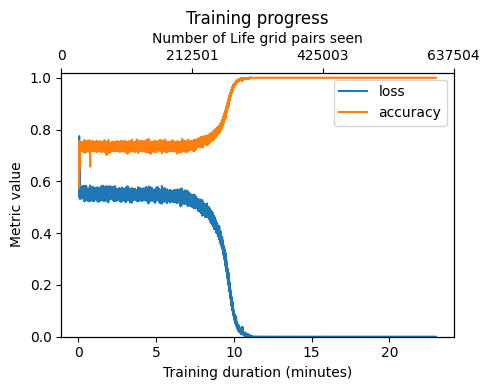

In [7]:
df = pd.DataFrame(iter_vals)

fig = plt.figure(figsize=[5, 4])
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

plt.ylim(0, 1.02)
ax1.plot(df["train_duration_seconds"] / 60, df["loss"], label="loss")
ax1.plot(df["train_duration_seconds"] / 60, df["accuracy"], label="accuracy")
ax1.set_ylabel("Metric value")
ax1.set_xlabel(r"Training duration (minutes)")
ax1.legend()

ax2.set_xticks(np.linspace(0, len(df) * batch_size, 4))
ax2.set_xlabel(r"Number of Life grid pairs seen")

plt.title("Training progress")
plt.tight_layout()

plt.savefig(f"plots/training_progress.png")
plt.show()

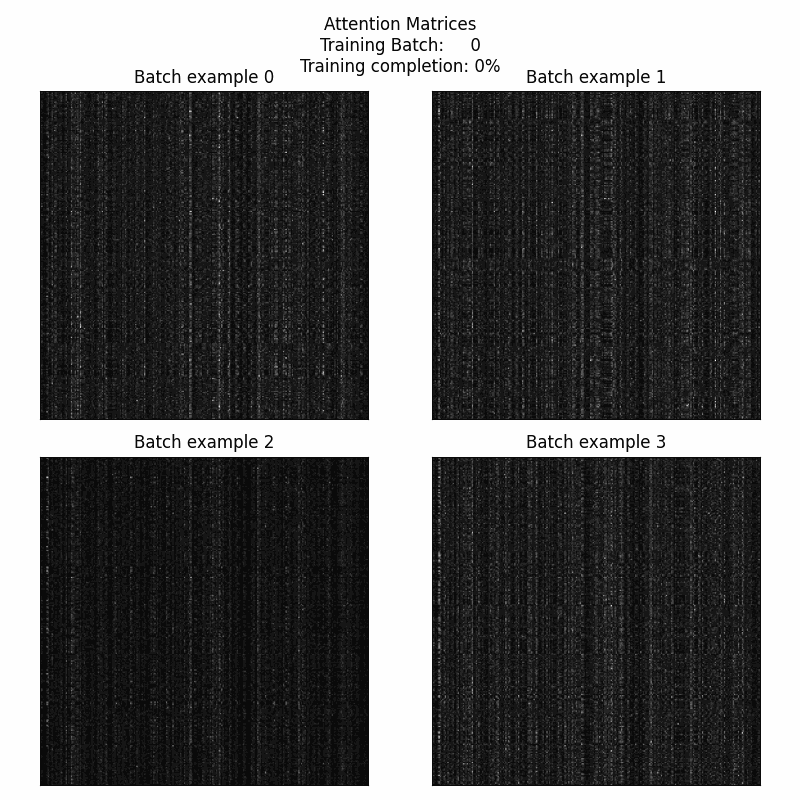

In [8]:
# Extract the matrices
matrices = [x["attention_matrix"] for x in saved_attention_matrices][::20]
batch_indices = [x["batch_idx"] for x in saved_attention_matrices][::20]

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
ims = [axes[i // 2, i % 2].imshow(matrices[0][i], cmap="gray") for i in range(4)]
for i, ax in enumerate(axes.flat):
    ax.set_title(f"Batch example {i}")
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle(
    f"Attention Matrix Examples\nTraining Batch: {0: 5d}"
)  # here so tight_layout works

plt.tight_layout()


def animate_func(i):
    for idx in range(4):
        ims[idx].set_array(matrices[i][idx])
    fig.suptitle(
        f"Attention Matrices\nTraining Batch: {batch_indices[i]: 5d}\nTraining completion: {batch_indices[i] / batch_indices[-1]:.0%}"
    )
    return ims


FPS = 8
anim = FuncAnimation(
    fig, animate_func, frames=len(matrices), interval=1000 / FPS, blit=True  # in ms
)
anim.save("plots/attention_matrix_training.gif", writer=PillowWriter(fps=FPS))
plt.close()

display(
    Image(data=open("plots/attention_matrix_training.gif", "rb").read(), format="png")
)

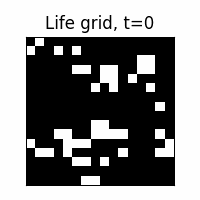

In [9]:
# Plot a Game of Life computed by the transformer...

before_grid = initialize_grid(seed=4343, grid_dim=grid_dim, p_alive=0.5)
grids = []
for _ in range(50):
    after_grid = next_life_step(before_grid)
    with torch.no_grad():
        after_grid_pred, _ = model(before_grid)
    after_grid_pred = after_grid_pred.detach().cpu().numpy()
    after_grid_pred = (after_grid_pred.reshape(grid_dim, grid_dim) > 0).astype(int)
    if not np.all(after_grid_pred == after_grid):
        raise RuntimeError("Model made a mistake")
    before_grid = after_grid_pred
    grids.append(before_grid.copy())

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
imshow = ax.imshow(grids[0], cmap="gray")
ax.set_title(f"Life grid, t=0")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()


def animate_func(i):
    imshow.set_array(grids[i])
    ax.set_title(f"Life grid, t={i}")
    return [imshow]


FPS = 8
anim = FuncAnimation(
    fig, animate_func, frames=len(grids), interval=1000 / FPS, blit=True  # in ms
)
anim.save("plots/life_grid_computed_by_transformer.gif", writer=PillowWriter(fps=FPS))
plt.close()
display(
    Image(
        data=open("plots/life_grid_computed_by_transformer.gif", "rb").read(),
        format="png",
    )
)